<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/ExploreHamiltonians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My somewhat silly attempt at a self-contained tutorial 🕵 on NNs + conservations laws + "real" applications. Hope this is useful! Things that are unclear to me or where potential connections need more investigation are highlighted in red, and there's plenty of these.

Hamiltonian mechanics is a branch of physics concerned with conservation laws and invariances. It can be regarded as an extension of Newtonian mechanics that is far more general and applies readily to different branches of physics and engineering. However, solving PDEs and enforcing conservation laws is  computationally challenging at the best of times and completely infeasible at others.

On the other hand, there is considerable interest in using deep neural networks to model dynamical systems, whether for system identification or long-term prediction purposes. We have long known about the effectiveness of convolutions for spatio-temporal data, and have since gone on to generalize the theory to link CNN / ResNet architectures to families of PDEs, ODE solvers, and discretization invariant methods to boost performance.

Existing neural networks that are used to model dynamical systems, irrespective of whether they predict states in discrete timesteps or in a continuous fashion, do not learn exact conservation laws or invariant quantities - to quote one of the papers below, they may drift away from the true dynamics of the system as small errors accumulate.

One motivating work for this is the section on Hyperbolic CNNs from Ruthotto and Haber (https://doi.org/10.1007/s10851-019-00903-1) although their work only addresses parameter-efficient training of networks for image-classification type problems. Another motivation comes from [Botev et al.](https://arxiv.org/abs/2111.05458) who attempt to compare performance of different physical priors in latent dynamics models on different benchmark datasets - it is not clear if the extra work needed to enforce constraints always translates to better performance. A more focused benchmarking paper for different energy conserving NNs specifically applied to physical problems comes from [Zhong et al.](https://proceedings.mlr.press/v144/zhong21a.html)

The methods we will see next, namely:

1. Hamiltonian NN (https://arxiv.org/abs/1906.01563) (see 🤦 P.S.)

2. Symplectic ODE Nets (https://arxiv.org/abs/1909.12077)

~~3. TRS-ODEN (https://arxiv.org/abs/2007.11362)~~

~~4. Hamiltonian OpInf (https://arxiv.org/abs/2107.12996)~~

(we will do 3 and 4 on a later date).

are modifications of existing methods / reduced-order models that attempt to endow models with better inductive biases, in the expectation that the resulting trained model can generalize better and enjoy predictable longer time rollouts.

We ask and answer to some extent the questions:

a. What is the Hamiltonian? How do we interpret it in terms of conservation laws?

b. What is symplectic integration? How does it tie in to Hamiltonian mechanics?

c. How do we write out the Hamiltonian for different systems of interest?

d. How do we learn it from data without explicit knowledge of its functional form? How hard of a learning problem is it when we try and impose such constraints? What if we don't have access to generalized momenta which are an integral part of the Hamiltonian formalism?

e. What is the typical improvement seen by enforcing the Hamiltonian in predictions over time?

This research area is very much in its infancy, so while there are many papers on the subject, there's still plenty to be done in figuring out how to apply these methods, comparing their performance on different tasks and simplify the learning process for real problems. By extension, the implementations I attempt are not super polished either, and serve the purposes of instruction rather than as a benchmark to build on.


P.S. Btw, there's Lagrangian Neural Networks too, though my rudimentary understanding is that this is more for convenience of representation rather than any specific advantage: you can [obtain the Hamiltonian from the Lagrangian](https://physics.stackexchange.com/questions/190471/constructing-lagrangian-from-the-hamiltonian) - see https://greydanus.github.io/2020/03/10/lagrangian-nns . The LNN Paper also presents an example $\color{olive}{\textrm{tied to GNNs if that's of interest. }}$ Their [GitHub](https://github.com/MilesCranmer/lagrangian_nns) also helps sum up the hype nicely if you doubt the claims 😏

|	| Neural Networks  | [Neural ODEs](https://arxiv.org/abs/1806.07366) | [HNNs](https://arxiv.org/abs/1906.01563)  | [DeLaN (ICLR'19)](https://arxiv.org/abs/1907.04490) | LNNs (this work) |
| ------------- |:------------:| :------------:| :------------:| :------------:| :------------:|
| Can model dynamical systems | ✔ | ✔ | ✔ | ✔ | ✔ |
| Learns differential equations | | ✔ | ✔ | ✔ | ✔ |
| Learns exact conservation laws | | | ✔ | ✔ | ✔ |
| Learns from arbitrary coords. |✔ | ✔|| ✔ | ✔ |
| Learns arbitrary Lagrangians | | |  | | ✔ |


Some philosophical musings on differing theories and the structure of physics - https://philsci-archive.pitt.edu/4961/1/Rev_structure.pdf

$\color{red}{\textrm{Free energy}}$?! - https://arxiv.org/pdf/1706.09010.pdf

### Chapter 1: Defining Hamiltonians and Lagrangians.

_Sidenote_: https://en.wikipedia.org/wiki/Broom_Bridge

I took a stab at reading [David Morin's chapter](https://bpb-us-e1.wpmucdn.com/sites.harvard.edu/dist/0/550/files/2023/11/cmchap15.pdf) on this topic -  so we will begin by briefly defining the principles of Newtonian, Lagrangian and Hamiltonian mechanics (_the latter two reinterpreting the former in ways that enabled solving problems handily in other domains!_)

#### Variational Calculus to setup the Lagrangian

The equations of motion for the Lagrangian framework come from defining a principle of least action, and solving it in a general framework where we try to find extremal values of integral functionals through the calculus of variations.

#### Defining H

A quantity denoted by $E$ defined as:

$$E \equiv \left(\sum_{i=1}^N \frac{\partial L}{\partial \dot{q}_i} \dot{q}_i\right) - L$$

represents the energy of the system.

The above rewritten in a certain way defines the Hamiltonian $H$.

Consider a particle undergoing 1D motion under the influence of a potential $V(x)$. ($x$ is Cartesian coordinates)

Then $L \equiv T - V = m\dot{x}^2/2 - V(x)$. This means $E$ takes the form:

$$E \equiv \frac{\partial L}{\partial \dot{x}} \dot{x} - L = 2T - (T - V) = T + V$$

aka $\color{olive}{\textrm{the total energy}}$. This is true even for arbitrary coordinates $q$ as long as $x=x(q)$ without any time dependence i.e. $x \neq x(q, t)$, or equivalently $q=q(x, t)$ (also $x = x(q, \dot{q})$) These complications are not considered in the book.
<!-- $\color{red}{\textrm{Write equations showing this below}}$ -->

**Example**: Particle undergoing 1-D motion under potential $V(x)$ ($x$ is Cartesian) has $L \equiv T - V = m (\dot{x})^2/2 - V(x)$ The expression for $E$ follows:

$E = (m \dot{x})\dot{x} - (m\dot{x}^2/2 - V(x)) = T + V$

So $E$ is the total energy in this scenario.

If we use $x(q) = Kq^5$ as the coordinate transformation, $L(q, \dot{q}) = F(q)\dot{q}^2 - V_u(q)$ and $E = F(q) \dot{q}^2 + V_u(q) = T + V$

But if $x = x(q, t)$, it can be shown that $E$ throws up an extra term:

$$E = T + V - m\left(\frac{\partial x}{\partial q}\frac{\partial x}{\partial t} \dot{q} + \frac{\partial x}{\partial t}^2\right)$$

> $\color{olive}{\textrm{Theorem:}}$ A necessary and sufficient condition for $E$ to be total energy of a system when the Lagrangian is expressed in coordinates $q_i$ is that $q_i$ are related to Cartesian coordinates $x_i$ ($q$ may be of smaller dimension than $x$) via (invertible) expressions of the form:

$$x_1 = x_1(q_1, q_2, \cdots)$$

$$\vdots$$

$$x_N = x_N(q_1, q_2, \cdots)$$

$\color{red}{\text{In any case, changing the coordinates won't change the underlying quantity, just its description.}}$

Trivial example for dimension of $q$: Particle constrained to move in $xy$ plane, which implies $z=0$. Other examples? Motion of pendulum?

*Start defining the Hamiltonian by rewriting $E$*

Get rid of the time derivative of $q$ by defining

$$p \equiv \frac{\partial L}{\partial \dot{q}}$$

$p$ is the *generalized / conjugate momentum* associated with $q$, but need not have the units of standard linear momentum!

Armed with $\dot{q}(q, p)$ (this inversion is not always trivial), we swap out $E$ for $H$ as standard practice for denoting a function of $q$ and $p$ ($L$ by contrast is always a function of $q$ and $\dot{q}$)

$$H(q, p) \equiv p \dot{q}(q, p) - L(q, \dot{q}(q, p))$$

$(q, p)$ will be the phase space coordinates from here on. These are functions of time only.

**TL;DR**: The Hamiltonian is the same as the total energy if the constraints and coordinate transformations are time independent and the potential energy is velocity independent.

*Hamilton's equations*:

_Least Action Principle_:




_Hamiltonian coordinates_:



_Moving from particles / point masses to the continuum_:

A quote from the text to emphasize that there's far harder problems where the HNN would actually be interesting:



> When solving ordinary mechanics problems with the Hamiltonian formalism,
you should keep in mind that the purpose is not to gain anything in efficiency, but
rather to become familiar with a branch of physics that has numerous indispensable
applications to other branches

Recipe for solving problems with Hamiltonian Method:

1. Calculate $T$ and $V$, get $L$ in whatever coordinates is the most convenient.

2. Calculate $p_i \equiv \partial L / \partial \dot{q_i}$

3. Solve for $H$



**Poisson Bracket Relations:**

The Poisson bracket of two functions, $f_1$ and $f_2$  where $f_1 \equiv f_1(q, p, t)$ and $f_2 \equiv f_2(q, p, t)$ is defined to be:

$$\{f_1, f_2\} \equiv \frac{\partial f_1}{\partial q}\frac{\partial f_2}{\partial p} - \frac{\partial f_1}{\partial p}\frac{\partial f_2}{\partial q}$$

Then, the total derivative for some $f(q, p, t)$ i.e. $\dot{f}$ (expand using chain rule):

$$\dot{f} = \frac{\partial f}{\partial q}\color{red}{\frac{\partial q}{\partial t}} + \frac{\partial f}{\partial p}\color{red}{\frac{\partial p}{\partial t}} + \frac{\partial f}{\partial t}$$

Replace highlighted terms from Hamilton's equations, and we end up with a Poisson bracket relation:

$$\dot{f} = \{f, H\} + \frac{\partial f}{\partial t}$$

When $f$ is not (directly) a function of time, $\dot{f} = \{f, H\}$

(some) Properties of Poisson brackets (PBs):
0. $\{f, H\}=0 \implies$ $f$ is a conserved quantity, Since Hamiltonian represents the total energy of the system, it is also conserved: $dH/dt=0$, $\{H, H\}=0$.

This is pretty useful when extending HM to systems like fluids, gases where motion of individual points cannot be easily specified in phase space. Then if we consider density (number of particles) $\rho$ per unit volume, we can show that the total derivative of $\rho$:

$$\frac{d\rho}{dt} = \frac{\partial \rho}{\partial t} + \{\rho, H\} = 0$$ i.e. though the shape of the phase-space volume changes, the phase-space density of the fluid remains constant ([Liouville's theorem](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_(Cline)/15%3A_Advanced_Hamiltonian_Mechanics/15.02%3A_Poisson_bracket_Representation_of_Hamiltonian_Mechanics))

This allows us to check  that some quantity/ies is a constant of motion by evaluating their Poisson bracket with $H$.

1. $\{f_1, f_1\} = 0$
2. $\{f_1, f_2\} = - \{f_2, f_1\}$. ($\color{red}{anticommutative!}$). I cannot fully appreciate this property. but one of the implications of this and $\{f_1, f_2\}$ being non-zero is related to whether two observables are independent and can be measured independently. This is generally more important for quantum mechanics i.e. where canonical coordinates do not commute, and you cannot measure both simultaneously with full accuracy.

3. $\{cf_1 + df_2, g\} = c\{f_1, g\} + d\{f_2, g\}$

4. $\frac{\partial}{\partial t}\{f_1, f_2\} = \left\{\frac{\partial f}{\partial t}, g\right\} + \left\{f, \frac{\partial g}{\partial t}\right\}$

The HEMs are actually Poisson bracket relations:

1. $\dot{q_k} = \{q_k, H\} = \frac{\partial H(q, p)}{\partial p_k}$

2. $\dot{p_k} = \{p_k, H\} = -\frac{\partial H(q, p)}{\partial p_i}$

Canonical coordinates should obey the following relations:

1. $\{q_i, q_j\} = 0$

2. $\{p_i, p_j\} = 0$

3. $\{q_i, p_j\} = \delta_{ij}$


$\color{olive}{\textrm{Final notation:}}$

$H$ instead of $E$. Many of these works use $\mathcal{H}$ but I am too lazy to type that over and over.

$$\frac{dq}{dt} = \frac{\partial H(q, p)}{\partial p}$$

$$\frac{dp}{dt} = -\frac{\partial H(q, p)}{\partial q}$$


$\color{olive}{\textrm{Legendre Transforms:}}$

Converting between $L$ and $H$

### Chapter 2: If you thought integration was hard...



Geometrical prettiness - https://physics.stackexchange.com/a/89036

### Chapter 3: Learning the Hamiltonian

### 3.1 When analytical form is known...

We are definitely considering harder problems than the canonical systems presented here, but it is instructive to see these anyways.
















**Hamiltonian Neural Networks**:

Inputs: $(q, p)$

Output: $H_\theta$

Calculate: $\frac{dq}{dt}, \frac{dp}{dt}$ from $H_{\theta}$


Integrate: $(q_1, p_1) = (q_0, p_0) + \int_{t_0}^{t_1} S_{H_\theta}(q, p) dt$

Loss function:

$\mathcal{L}_{HNN}= \left \lvert \left \lvert \frac{\partial H_{\theta}}{\partial p} - \frac{dq}{dt} \right \rvert \right \rvert_2 + \left \lvert \left \lvert \frac{\partial H_{\theta}}{\partial q} + \frac{dp}{dt} \right \rvert \right \rvert_2$



**Note**:

For $n$ particles / bodies, $(\mathbf{q}, \mathbf{p})= ((q_1, q_2, \cdots, q_n), (p_1, p_2, \cdots, p_n)$ and:

$\dot{q}_i = \frac{\partial H(q, p)}{\partial p_i}  \quad \dot{p}_i = -\frac{\partial H(q, p)}{\partial q_i}$

i.e. $2n$ coupled first order ODEs would be solved, while for the Euler-Lagrange equations it is $n$ second-order ODEs.

One small gotcha is that the general expression for the Hamiltonian:

$$H(\mathbf{q}, \mathbf{p}) = \frac{1}{2}\mathbf{p}^T \mathbf{M}^{-1}(\mathbf{q})\mathbf{p} + V(\mathbf{q})$$ with  multiple degrees of freedom requires computing inverse of SPD mass matrix $\mathbf{M}(\mathbf{q})$, and this is approximated with learnable parameters too when $\mathbf{M}$ is not available. This is precisely what's done in the [SymODEN paper](https://arxiv.org/pdf/1909.12077). They use Cholesky decomposition to ensure PD and stabilize training via adding $\epsilon^2 I$. The definition of $\mathbf{M}$ will show up in some codes as the [Levi-Civita permutation tensor](https://en.wikipedia.org/wiki/Levi-Civita_symbol) e.g https://github.com/greydanus/hamiltonian-nn/blob/bcc362235dc623ffe48f22ccc22417e02e9803b4/hnn.py#L63.

In [ ]:
import torch
import torch.nn as nn

$\color{olive}{\textrm{Performance on non-conservative systems?}}$ - as it turns out, many of these papers do consider examples from actual experiments like measurements on a real pendulum, where there is dissipation on account of air resistance. The HNN has smaller error compared to the baseline NN, but always assumes a conserved quantity exists - so cannot account for friction. This implies that would have to be modeled separately. A later work by the same author does precisely this, see [Dissipative HNNs](https://greydanus.github.io/2022/01/25/dissipative-hnns/).

This is also a very nice segue into reversibility: see section 3.1 of [Huh et al.](https://proceedings.neurips.cc/paper/2020/file/db8419f41d890df802dca330e6284952-Paper.pdf)

**Time reversible Hamiltonian ODE-Nets**:

(they add $\color{olive}{\textrm{another loss term}}$ based on the fact that many kinds of classical dynamics are conservative and reversible). They also show better results under some settings when the system is irreversible.

Use Leapfrog solver (symplectic nature) for the following augmented NODE system:
(this is summarizing the HNN procedure)

$$\begin{bmatrix} \tilde{q}_{i+1} \\ \tilde{p}_{i+1} \end{bmatrix} = \texttt{ODESolve} \left( \begin{bmatrix} \tilde{q}_{i} \\ \tilde{p}_{i} \end{bmatrix}, \Delta t_i, S_{H_\theta} \right)$$

**Time reversal loss**:

Time-reversal symmetry exists if there exists an operator $R$ s.t.:

$$\frac{d R(x)}{dt} = -f(R(x))$$

Do backward time evolution and calculate:


$$\mathcal{L}_{\textrm{TRS}} = \sum_{i=0}^{T-1} \left \lvert \left \lvert R(\texttt{ODESolve}(\tilde{x}_i, \Delta t_i, S_{H_\theta})) - \texttt{ODESolve}(\tilde{x_R}_i, -\Delta t_i, S_{H_\theta})\right \rvert \right \rvert_2^2$$

$\color{red}{\textrm{Do they model the loss in the fitting of the states in the HNN paper?}}$

$\color{red}{\textrm{If not, how would a combined loss term look? one example is:}}$

$$\mathcal{L}_{\textrm{total}} = \mathcal{L}_{\textrm{ODE}} + \lambda_1 \mathcal{L}_{\textrm{HNN}} + \lambda_2 \mathcal{L}_{\textrm{TRS}}$$

Here's how I think it could have an advantage over the other approaches we could consider:

1. While PINNs may claim to be "game-changers" for applied math, by trying to incorporate physics via a soft penalty on the conservation law, note that these are notoriously difficult to train, and fail very easily when the parameters of the underlying systems are changed. While [there are works to alleviate these challenges](https://arxiv.org/abs/2109.01050), these impose very little inductive bias and I wouldn't be inclined to use them on any real problem no matter the hype.

(after all, theory and algorithms for optimization methods are as well-established as numerical methods - there really is no free lunch ! we end up losing a lot more than we gain by trying to optimize for the PDE residual instead of smartly learning it from data)

2. Neural ODEs are not too bad, but we have to go to a lot of trouble when designing network architectures for high-dimensional fields e.g. either image to image mapping, or learn the NODE in latent space, etc. HNN-style methods simplify the learning problem - we are not predicting the state directly, but a scalar Hamiltonian! (and possibly a few other outputs depending on the specific method used). The Hamiltonian is used to derive the total derivative of our state which can be integrated to yield the predictions.

This simplification makes existing methods (e.g. CNN with fully connected layers at the end) far more compatible with the problem at hand instead of futzing around with operators and implicit methods (_more on this later!_)

On second thoughts, though we can get away with a scalar, we are still defining its derivative w.r.t a high dimensional image. This could still be problematic.


Actually, works such as [regularized Neural ODEs](https://arxiv.org/pdf/2002.02798.pdf) which solve an augmented system to simplify the dynamics with principles from optimal transport $\color{olive}{\textrm{are tied to kinetic energy of the system }}$. There probably isn't a good comparison on how well they do next to HNNs. It is also unclear to me if they are enforcing a part of or the same constraints differently.

3. A nice point is that as long as some quantity is conserved (it need not be total energy of the system either) (if we are not looking to model dissipation in the simplest setting) we need not necessarily be able to write out an analytical expression for the Hamiltonian - it can still be learnt and incorporated in the above setup. We would merely need to be careful in defining our position and momentum coordinates, and for the latter case, finding robust alternatives to finite differences if we are dealing with noisy data.

**Ideal Comparisons**:

1. Different choices of integrator (symplectic vs regular) (we want symplectic to do better?)

2. Access to non-canonical coordinates as done in symplectic ODE net paper.

3. Lagrangian NN (from same authors) (we want both to be comparable)

4. Add dissipation and check with and without reversibility loss (unsure of what to expect)

We will probably leave these for part 2 of the tutorial. Part 1 is for reproducing simple examples and making some changes to suit our application problems.

**Data generation**

(in all examples, set $m=1$ for simplicity)

1. _Ideal spring-mass_:

$$H = \frac{1}{2} k q^2 + \frac{p^2}{2m}$$

Conjugate momentum $p = m\dot{q}$ (noting a special case of $n=1$, where $\mathbf{M}^{-1} = 1/m$)

![](https://github.com/greydanus/hamiltonian-nn/blob/master/static/overall-idea.png?raw=true)

Figure from Greydanus et al.

Verify that the above expression satisfies Poisson bracket relations:

$$\{f_1, f_2\} \equiv \frac{\partial f_1}{\partial q}\frac{\partial f_2}{\partial p} - \frac{\partial f_1}{\partial p}\frac{\partial f_2}{\partial q}$$

$$H = \frac{1}{2} k q^2 + \frac{p^2}{2m}$$

Conjugate momentum $p = m\dot{q}$

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
import torch
import torch.nn as nn
# from torch import autograd
import autograd
import autograd.numpy as np
from torch import Tensor
from typing import Callable, Union
import scipy.integrate

In [ ]:
def hamiltonian_sm(coords, m=1, k=1):
    """
    Hamiltonian for spring-mass system
    """
    q, p = np.split(coords,2)
    H = (1/2)*k*(q**2) + (1/2)*(p**2/(2*m))
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_sm)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

From https://github.com/greydanus/hamiltonian-nn/blob/bcc362235dc623ffe48f22ccc22417e02e9803b4/hnn.py#L63 for mass matrix:

In [ ]:
def permutation_tensor(n, assume_canonical_coords=False):
  M = None
  if assume_canonical_coords:
      M = torch.eye(n)
      M = torch.cat([M[n//2:], -M[:n//2]])
  else:
      '''Constructs the Levi-Civita permutation tensor'''
      M = torch.ones(n,n) # matrix of ones
      M *= 1 - torch.eye(n) # clear diagonals
      M[::2] *= -1 # pattern of signs
      M[:,::2] *= -1

      for i in range(n): # make asymmetric
          for j in range(i+1, n):
              M[i,j] *= -1
  return M

In [ ]:
permutation_tensor(2), permutation_tensor(2, assume_canonical_coords=True)

(tensor([[ 0.,  1.],
         [-1.,  0.]]),
 tensor([[ 0.,  1.],
         [-1., -0.]]))

In [ ]:
permutation_tensor(3), permutation_tensor(3, assume_canonical_coords=True)

(tensor([[ 0.,  1., -1.],
         [-1.,  0.,  1.],
         [ 1., -1.,  0.]]),
 tensor([[ 0.,  1.,  0.],
         [ 0.,  0.,  1.],
         [-1., -0., -0.]]))

The simplest way to change the syntax for a regular Neural ODE is to write new `forward` and `integrate` functions, where the former computes `H` and the latter is used for integration of its partial derivatives.

**Define class for Hamiltonian NN**

**Train and Predict**

**Parametrizing H**:

One more idea which is particularly useful to check for us is examining a parametrized version of the Hamiltonian, both for a simple example and an example where we learn dynamics in the latent space. For e.g. if an ideal pendulum has the following expression for $H$:

$$H = 2mgl(1 - \cos q) + \frac{l^2 p^2}{2m}$$

and suppose we have training data for different $m$ and $l$ (say $\mu = [m, l]$ encodes this knowledge) then we may want a neural network with input features: $q, p, \mu$ and learn a Hamiltonian $H(q, p, \mu)$.

One plausible way to compare is to use a regular HNN without any augmentation and check the trajectories it produces (we hope that they don't look correct for our hypothesis to hold).

One fudging factor here that affects our interpretation of the above is that changing $l$ would reflect in the position? whereas changing $m$ wouldn't show up in the test initial condition but affect the value of $H$! Perhaps the best way is to tune $m$.

**Dissipation Term**:

Currently a little out of scope for this tutorial. Refer:

1. Chapter 10 of [Cline's textbook](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_(Cline))

2. Examples from [the TRS-ODEN paper](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fabs%2F2007.11362)

**Example where generalized / conjugate momentum expression differs from usual $\dot{q}$** ??

Here we can also try and use the idea from the [symplectic ODE-Net paper by Zhong et al.](https://arxiv.org/pdf/1909.12077), where we will assume access to $\dot{q}$ instead of $p$.

### 3.2 Learning from "real" data

Pendulum experiment from https://github.com/greydanus/hamiltonian-nn/blob/master/analyze-pixels.ipynb

This takes advantage of the fact that a low-dimensional Hamiltonian system is embedded in the video data, therefore we can split a latent space of even dimensions into projected positions and momenta.

### 3.3 "Parametrizing" H

### Chapter 4: Moving to the continuum





We will perform experiments with Burgers equation to begin. Right now we will focus on predictive ability compared to a baseline NN (can this be a NeuralODE?), and with regular and shifted Operator Inference. How much mileage can we get from the HNN formalism?

**Note 1** : I don't know a ground-truth expression for whatever quantity gets conserved over here, so my POV is using sOpInf as a "competitive benchmark".

**Note 2**: The implementation of the HNN in their GitHub is a little-more low-level and invokes `torch.autograd`, we may just end up using `torchdiffeq`.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import scipy.linalg as la
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

The settings for Burgers' equation are taken from the sOpInf ROM Demo here: https://github.com/opaliss/Space-Weather-ROM/blob/main/Burgers/sOpInf-Inviscid-Burgers-Eq-Quadratic-Form-CCE-Noise-5.ipynb


$$\frac{\partial u}{\partial t} + u \frac{\partial{u}}{\partial{x}}=0$$


It is written in conservative form with a flux function $g(\tilde{u}) = \frac{1}{2}\tilde{u}^2 + \frac{dc}{dt} \tilde{u}$ as:


$$\frac{\partial \tilde{u}}{\partial t} +  \frac{\partial g(\tilde{u})}{\partial{\tilde{x}}}=0$$

In [ ]:
# number of mesh points in the T (time) axis.
m = 1000
# number of mesh points in X (spatial) axis.
n = 500
# final time.
T = 2
# boundary of x [a, b].
a = 0
b = 3

t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)[:-1]

initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

In [ ]:
# flux function
def flux(u):
    return 0.5*(u**2)

def solve_upwind_scheme(initial_condition, t_vec, x_vec):
    """ solve a 1-d advection diffusion equation using the first order conservative upwind scheme"""
    U = np.zeros((len(x_vec), len(t_vec)))

    U[:, 0] = initial_condition

    dt = np.mean(t_vec[1:] - t_vec[:-1])
    dx = np.mean(x_vec[1:] - x_vec[:-1])

    for ii in range(len(t_vec)-1):
        for jj in range(len(x_vec)):
            if (U[jj, ii] * dt/dx) > 1:
                print("Warning: CFL condition violated. ")

            # update the next cell.
            U[jj, ii+1] = U[jj, ii] + (dt/dx)*(flux(U[jj-1, ii])  - flux(U[jj, ii]))
    return U

In [ ]:
U_sol = solve_upwind_scheme(initial_condition, t_vec, x_vec)

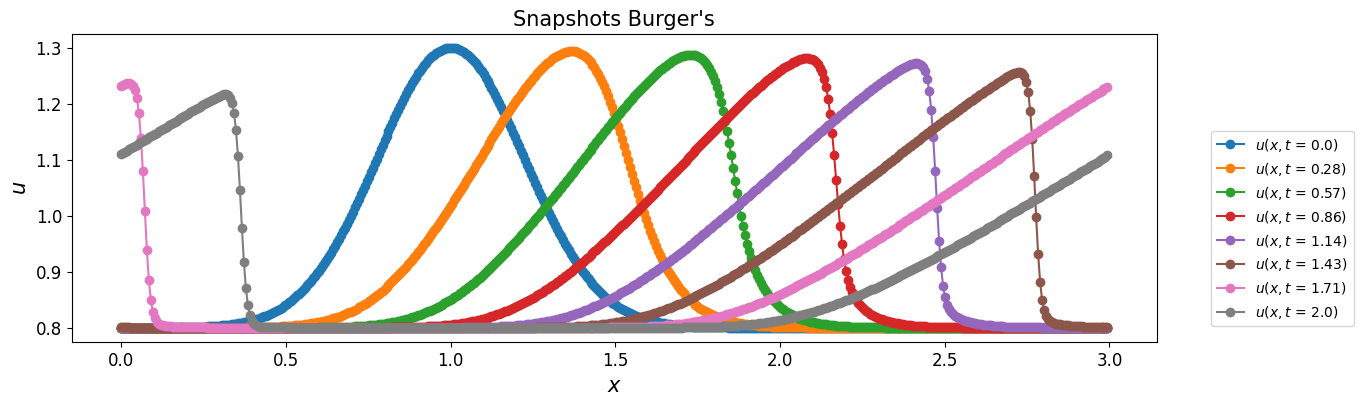

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
for ii in np.linspace(0, len(t_vec) -1, 8):
    ax.plot(x_vec, U_sol[:, int(ii)], "-o", label="$u(x, t$ = "+ str(round(t_vec[int(ii)], 2)) + ")")
    ax.set_xlabel("$x$", fontsize=15)
    ax.set_ylabel("$u$", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title("Snapshots Burger's", fontsize=15)
    ax.legend()
    ax.legend(loc=(1.05, .05))

Let's write the method for modeling the wave equation with HNN first, then we will switch to Burgers equation. The Burgers' equation doesn't appear to be a canonical Hamiltonian system. $\color{red}{\textrm{why is it harder to derive this though?}}$

**Final Test**: Consider an example where we wish to solve dynamics from real data on the lines of their PixelHNN example. How far can we get with the HNN? This is where we are firmly in trial-and-error territory. In fancy ML terms we are looking for better $\color{olive}{\textrm{zero-shot generalization}}$ and better $\color{olive}{\textrm{predictive accuracy}}$.


**Note** We may want to avoid a latent space when we cannot characterize the dynamics precisely there. Plus, solving a differential equation in the latent space,
($\color{olive}{\textrm{from experience, YMMV}}$) doesn't necessarily result in great reconstructions through the decoder and raises additional problems in doing UQ. However, image-to-image mapping is not straightforward either.




> “From this point forth, we shall be leaving the firm foundation of fact and journeying together through the murky marshes of memory into thickets of wildest guesswork.” - Dumbledore, Half Blood Prince 🎩



**Possible Comparisons?**
1. PixelHNN (from Hamiltonian NN GH)

2. SINDy Autoencoder (from https://github.com/kpchamp/SindyAutoencoders/tree/master/examples/pendulum)


**Extra work to check**:

https://arxiv.org/abs/2010.13581

Enforcing constraints with Lagrangian multipliers for better accuracy and data efficiency?

The above concept seems fine when you look at their example (rewriting things in Cartesian coordinates for pendulum instead of angles and adding constraint that the masses distance from pivots does not change), not sure how it translates to real problems though! My takeaway was it matters more when you have multi-body systems and the Hamiltonian to be learnt is super convoluted.

In closing here are some additional remarks to give a big picture overview of the literature. First, the use of a 4th order RK scheme, while meant to encourage higher accuracy, means that the solution can still stray from the manifold over long enough times. The non-symplectic integrator used here is akin to a "physics ignorant learning framework" (see reference 2). Using different schemes at train and test time e.g. RK for train and leapfrog for test, would not account for the data collection process. Finally, different works try to address different shortcomings of these methods:

1. [Zhong et al.](https://arxiv.org/abs/1909.12077) consider generalization of Hamiltonian dynamics to learn external control schemes in an augmented NODE scheme with derivations for learning Hamiltonian with generalized coordinates (in terms of $q$ and $\dot{q}$ only since generalized momentum may not be available).

2. [Galioto and Gorodetsky](https://doi.org/10.1109/CDC42340.2020.9303852) provide a Bayesian framework for low-dimensional systems that accounts for model-form uncertainty, and errors in the integration scheme used. They also ensure that their discrete time propagators conserve reversibility, symplecticness and so on. Polynomial approximations are used to parametrize the potential $V$.

3. [Sharma et al.](https://doi.org/10.1016/j.physd.2021.133122) perform both model order reduction and data-driven learning: learn a low-dimensional symplectic subspace from full trajectories and also fit operators in a structure preserving way i.e. through deriving equations of motion for a specific form of the Hamiltonian for the reduced trajectories. This is an extension of the regression-based OpInf framework to the structure-preserving case.

(1 and 3 are distinctly non-Bayesian approaches.)

What we are (eventually) looking for is a learning scheme to accomplish 1. Bayesian modeling 2. Active learning / experimental design for deterministic or probabilistic surrogates - both combined with dimensionality reduction - these may rely on simpler choices of surrogate models as done in 3 or neural networks in a more challenging use case.

**My conclusions** (with a pinch of salt):

1. Depending on your interest, you can either do _physics for ML_ (physics-inspired ML architectures for distinctly non-physics tasks e.g. image classification) or _ML for physics_ (embedding NNs into actual equations to describe and predict a system). Though if you abstract things out far enough it may turn out that this kind of classification is superfluous.

2. Hamiltonians are incredibly powerful as a modeling perspective in the latter case. But they can make the learning problem much harder in some cases - there is no free lunch (see my note about the explicit constraints paper). The point is that if your shiny new ML model with Hamiltonians doesn't immediately do well, there's a strong possibility that it may need simplifications before the invariances actually show up. This may play a big part when the quantity of available training data is small.

3. As a knock-on effect, apple-to-apple comparison of architectures may not necessarily be possible, and needs more studies with canonical examples.

4. Latent dynamics identification is an equally hard problem, and relies very heavily on having prior knowledge (i.e. whether the original system embeds data with lower dimensional coordinates that obey some physical laws, extent of dissipation, true degrees of freedom, etc.). Blindly applying such methods may not work compared to more general architectures.

5. We also need more consensus on suitable metrics to figure out how well a model does. (conservation? extrapolation? reconstruction errors?)

And that's it. No part 2 of the HCU 🎥
 hopefully!

> There once was a principle fine,

> Least action, its aim to define.

> Hamilton played, With this path as he weighed

> Where particles dance on a line.

(ChatGPT, 2024)
